In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [3]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'n1wr',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '11wr',
        'map_n1': 'n1kv',
        'map_11': '11kv',
        
        'bytestream_n1_read': 'n1rd',
        'bytestream_11_read': '11rd',
        'map_n1_read': 'n1kvrd',
        'map_11_read': '11kvrd'
    }
    return mapping.get(ename, ename)

In [4]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [5]:
def plot_throughput_trace(trace, md, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    label = md.group('expr')
    label = short_ename(label)
    ax.plot(trace.completed, trace.throughput, label=label)
    #ax.set_title('Single OSD Throughput (Jewel 2016)')
    ax.set_ylim(0, 50000)
    ax.set_ylabel('Appends per Second per OSD')
    ax.set_xlabel('Time (Sec)')

In [6]:
def plot_traces(traces, fn, finish=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        plot_throughput_trace(trace_data, md, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax


In [14]:
def plot_read_write(filenames, name):
    sorted(filenames)
    read_traces = filter(lambda fn: '_read_sw' in fn, filenames)
    ax = plot_traces(list(read_traces), name, finish=False)
    lgd = ax.legend(loc='best', ncol=2)#, bbox_to_anchor=(0.42,0.42), bbox_transform=plt.gcf().transFigure)
    plt.savefig('%s_reads.png' % name, dpi=300, bbox_inches='tight')
    
    write_traces = filter(lambda fn: fn not in read_traces, filenames)
    ax = plot_traces(list(write_traces), '%s_writes.png' % name, finish=False)
    lgd = ax.legend(loc='best', ncol=2)
    plt.savefig('%s_writes.png' % name, dpi=300, bbox_inches='tight')

# 1 NVMe Device

The RocksDB and RocksDB WAL go on partition 1 (100MB) and the data goes on partition 2 (894GB). Apparently specifying the journal as a separate device does not doing anything. 

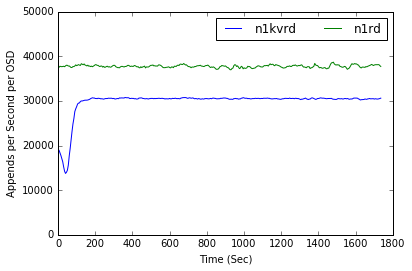

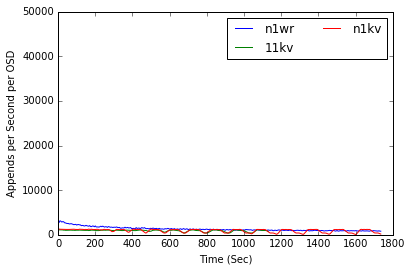

In [15]:
plot_read_write(glob.glob('results.pd.librados_read_data_jrnl_nvme_bluestore.pl1.05-22-2016_17-51-33/*.log'), 'data_bluestore_nvm')

# 1 NVMe Device

This is an attempt to keep all the stuff on one device -- but it turns out `ceph-disk` (which is used by `ceph-deploy`) isn't smart enough to figure out how to do 2 devices.

In [16]:
#plot_read_write(glob.glob('results.pd.librados_read_data_nvme_bluestore.pl1.05-22-2016_13-06-37/*.log'), 'data_bluestore_nvm2')

# Vary Write Size

Here we run all experiments and change the size of the log `entry_size`. 

11rd 37468.9236111
11kvrd 30951.8236111
n1rd 40710.7875
n1kvrd 31696.9875


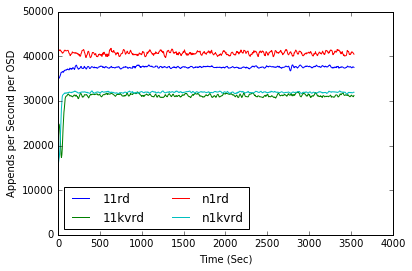

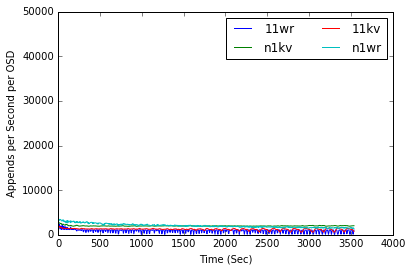

In [17]:
traces = glob.glob('results.pd.librados_read_data_jrnl_nvme_bluestore.pl1.05-22-2016_22-48-38/*es-128*.log')
plot_read_write(traces, 'data_bluestore_nvm2')
for filename in traces:
    trace_data = read_trace(filename)
    trace = pd.read_table(filename, sep=" ", header=None, names=("completed", "throughput"))
    label = short_ename(parse_filename(filename).group('expr'))
    if "rd" in label:
        print label, trace['throughput'].mean()

11rd 37468.9236111
11kvrd 30951.8236111
n1rd 40710.7875
n1kvrd 31696.9875


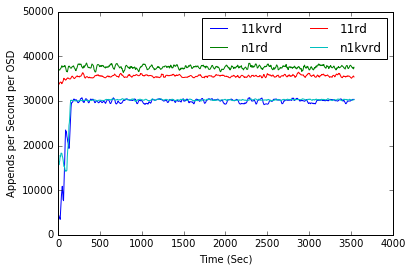

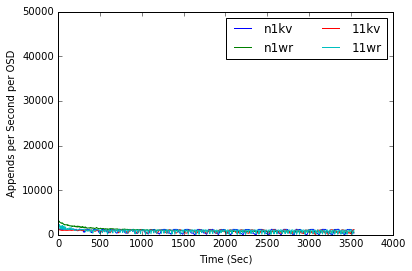

In [20]:
traces = glob.glob('results.pd.librados_read_data_jrnl_nvme_bluestore.pl1.05-22-2016_22-48-38/*es-1024*.log')
plot_read_write(traces, 'data_bluestore_nvm2')
traces = glob.glob('results.pd.librados_read_data_jrnl_nvme_bluestore.pl1.05-22-2016_22-48-38/*es-128*.log')
for filename in traces:
    trace_data = read_trace(filename)
    trace = pd.read_table(filename, sep=" ", header=None, names=("completed", "throughput"))
    label = short_ename(parse_filename(filename).group('expr'))
    if "rd" in label:
        print label, trace['throughput'].mean()

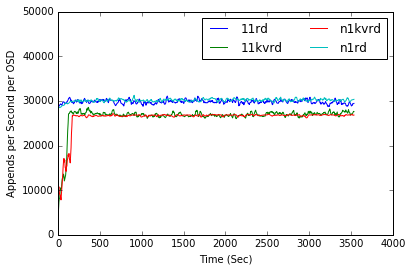

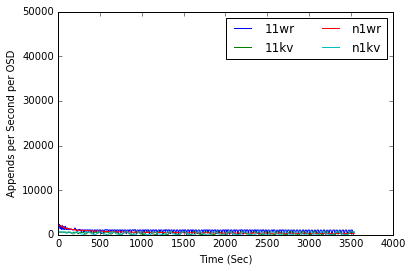

In [19]:
plot_read_write(glob.glob('results.pd.librados_read_data_jrnl_nvme_bluestore.pl1.05-22-2016_22-48-38/*es-4096*.log'), 'data_bluestore_nvm2')